In [1]:
import json
import os
import sys
from pathlib import Path

import dabest
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd
import yaml

from mne.time_frequency import AverageTFR, EpochsTFR, tfr_morlet, tfr_multitaper
from mne_bids import BIDSPath
from mne_bids.read import read_raw_bids
from mne_bids.tsv_handler import _from_tsv
from ptitprince import PtitPrince as pt
from rerf.rerfClassifier import rerfClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc, 
    accuracy_score, 
    cohen_kappa_score, 
    make_scorer, 
    plot_confusion_matrix, 
    roc_auc_score, 
    roc_curve
)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from sklearn.utils import check_random_state
from tqdm import tqdm

from cv import fit_classifiers_cv, initialize_classifiers
from functions.move_experiment_functions import (
    get_event_data, 
    get_preprocessed_labels,
)
from functions.time_window_selection_functions import (
    bootstrap_independence_test,
    bootstrap_independence_test_OLS,
    get_event_durations, 
    plot_event_onsets,
    plot_event_durations,
    plot_durations_by_label_raincloud,
    plot_durations_by_label_kde,
    plot_durations_cv_split,
)

if os.path.abspath("../io") not in sys.path:
    sys.path.append(os.path.abspath("../io"))

from read import read_dataset, read_trial, get_trial_info, _get_bad_chs
from utils import NumpyEncoder
from experiments import cv_fit
from plotting import (
    plot_signals,
    plot_spectrogram,
    plot_epoch_time_series,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices, 
    plot_classifier_performance,
    plot_roc_aucs,
    plot_accuracies,
)

plt.rcParams.update({
    "font.family": "sans-serif", 
    "font.size": 14
})

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Set paths and experiment defaults

In [2]:
with open(Path(os.path.abspath('')) / "config.yml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

with open(Path(os.path.abspath('')) / "metadata.yml") as f:
    metadata = yaml.load(f, Loader=yaml.FullLoader)

bids_root = Path(config["bids_root"])
results_path = Path(config["results_path"])

print(f"bids_root: {bids_root}")
print(f"results_path: {results_path}")

bids_root: /Volumes/Mac/research/data/efri
results_path: /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/derivatives/workstation_output


In [3]:
subject = "efri07"
path_identifiers = dict(subject=subject, session="efri", task="move", 
                        acquisition="seeg", run="01", suffix="ieeg", 
                        extension=".vhdr", root=bids_root)
bids_path = BIDSPath(**path_identifiers)

In [4]:
picks = ["B7", "G8"]
nfreqs = 30
lfreq, hfreq = (1, 200)

rng = 1
n_splits = 5
cv = StratifiedKFold(n_splits)
metrics = dict(
    accuracy="accuracy",
    cohen_kappa_score=make_scorer(cohen_kappa_score),
    roc_auc_ovr="roc_auc_ovr",
)

label_names = {0: "Down", 1: "Right", 2: "Up", 3: "Left"}

## Visualize raw SEEG data

In [5]:
epochs, labels = get_event_data(bids_path, tmin=-1.5, tmax=1.25, event_key='Left Target')

Extracting parameters from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Reading 0 ... 2613999  =      0.000 ...  1306.999 secs...


/Users/ChesterHuynh/.local/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any electrodes.tsv associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Volumes/Mac/research/data/efri/sub-efri07/**/sub-efri07_ses-efri*electrodes.tsv"
  warn(msg)
/Users/ChesterHuynh/.local/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any coordsystem.json associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Volumes/Mac/research/data/efri/sub-efri07/**/sub-efri07_ses-efri*coordsystem.json"
  warn(msg)


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 sec)

Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Left Target', 'Reserved (End Trial)', 'Reserved (Start Trial)', 'Reward', 'Show Center', 'Speed Fail', 'Speed Feedback', 'Speed Instruction']
Not setting metadata
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Loading data for 96 events and 5501 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-dom

/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/move_exp/functions/move_experiment_functions.py:28: RuntimeWarning: filter_length (6601) is longer than the signal (5501), distortion is likely. Reduce filter length or filter a longer signal.
  new_epochs = epochs.filter(l_freq=1, h_freq=fs / 2 - 1)


Dropped 20 epochs: 3, 4, 9, 12, 13, 33, 38, 40, 41, 48, 51, 53, 68, 76, 81, 82, 86, 87, 90, 95


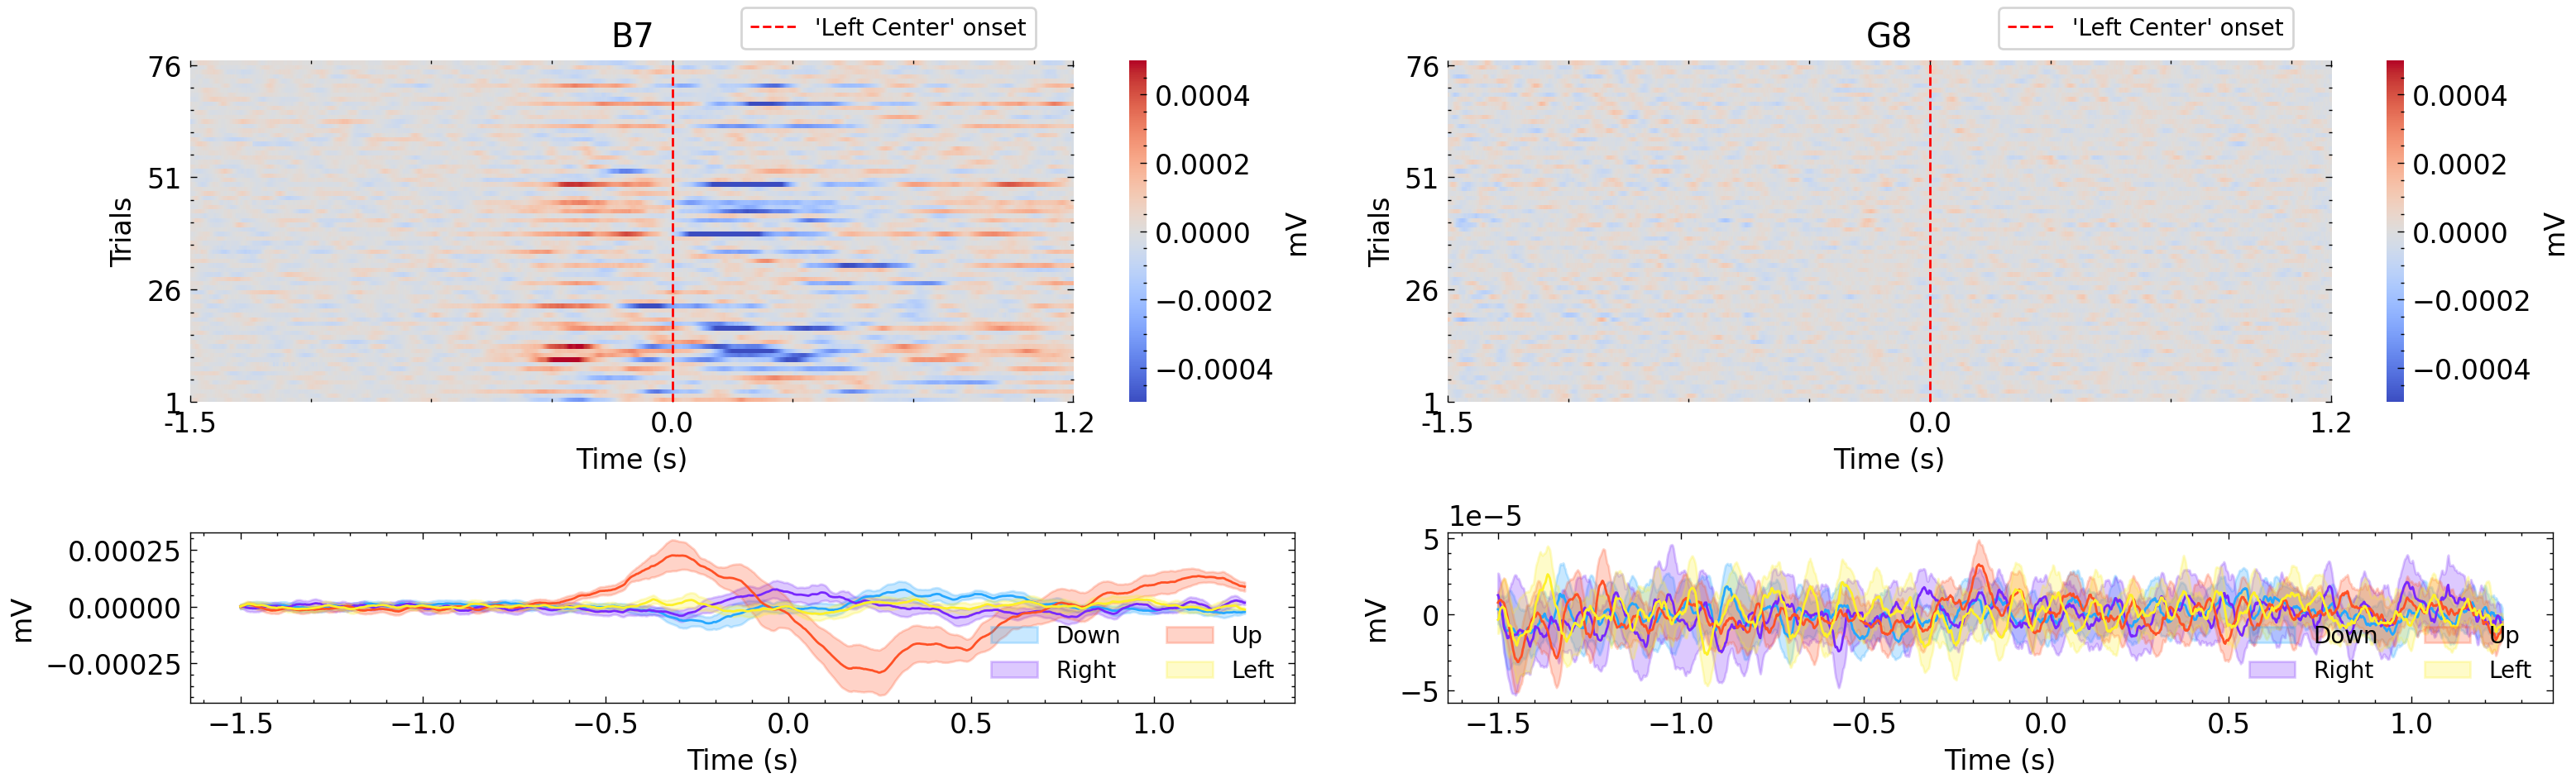

In [6]:
# make channels first axis
plt.rcParams.update({"font.size": 12})
fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [2, 1]}, figsize=(16, 5), dpi=200)
axs = axs.flatten()
plot_epoch_time_series(epochs, picks, vmin=-5e-4, vmax=5e-4, axs=axs[:2]);
plot_signals(epochs, labels, picks=picks, axs=axs[2:])
axs[2].set_title("")
axs[3].set_title("")
fig.tight_layout();

## Visualize Spectrogram

In [7]:
epochs = read_dataset(bids_path, tmin=-1.5, tmax=1.25, event_key='Left Target', notch_filter=False)

Extracting parameters from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Left Target', 'Reserved (End Trial)', 'Reserved (Start Trial)', 'Reward', 'Show Center', 'Speed Fail', 'Speed Feedback', 'Speed Instruction']
Not setting metadata
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated


/Users/ChesterHuynh/.local/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any electrodes.tsv associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Volumes/Mac/research/data/efri/sub-efri07/**/sub-efri07_ses-efri*electrodes.tsv"
  warn(msg)
/Users/ChesterHuynh/.local/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any coordsystem.json associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Volumes/Mac/research/data/efri/sub-efri07/**/sub-efri07_ses-efri*coordsystem.json"
  warn(msg)


### Morlet wavelet transform

In [8]:
nfreqs = 30
lfreq, hfreq = (1, 200)
freqs = np.logspace(*np.log10([lfreq, hfreq]), num=nfreqs)
n_cycles = freqs / 3.0

morlet_power = tfr_morlet(
    epochs, freqs=freqs, n_cycles=n_cycles, average=False, return_itc=False, decim=3, n_jobs=-1
)

Loading data for 96 events and 5501 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   44.0s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:  4.6min finished


Not setting metadata


Applying baseline correction (mode: zscore)


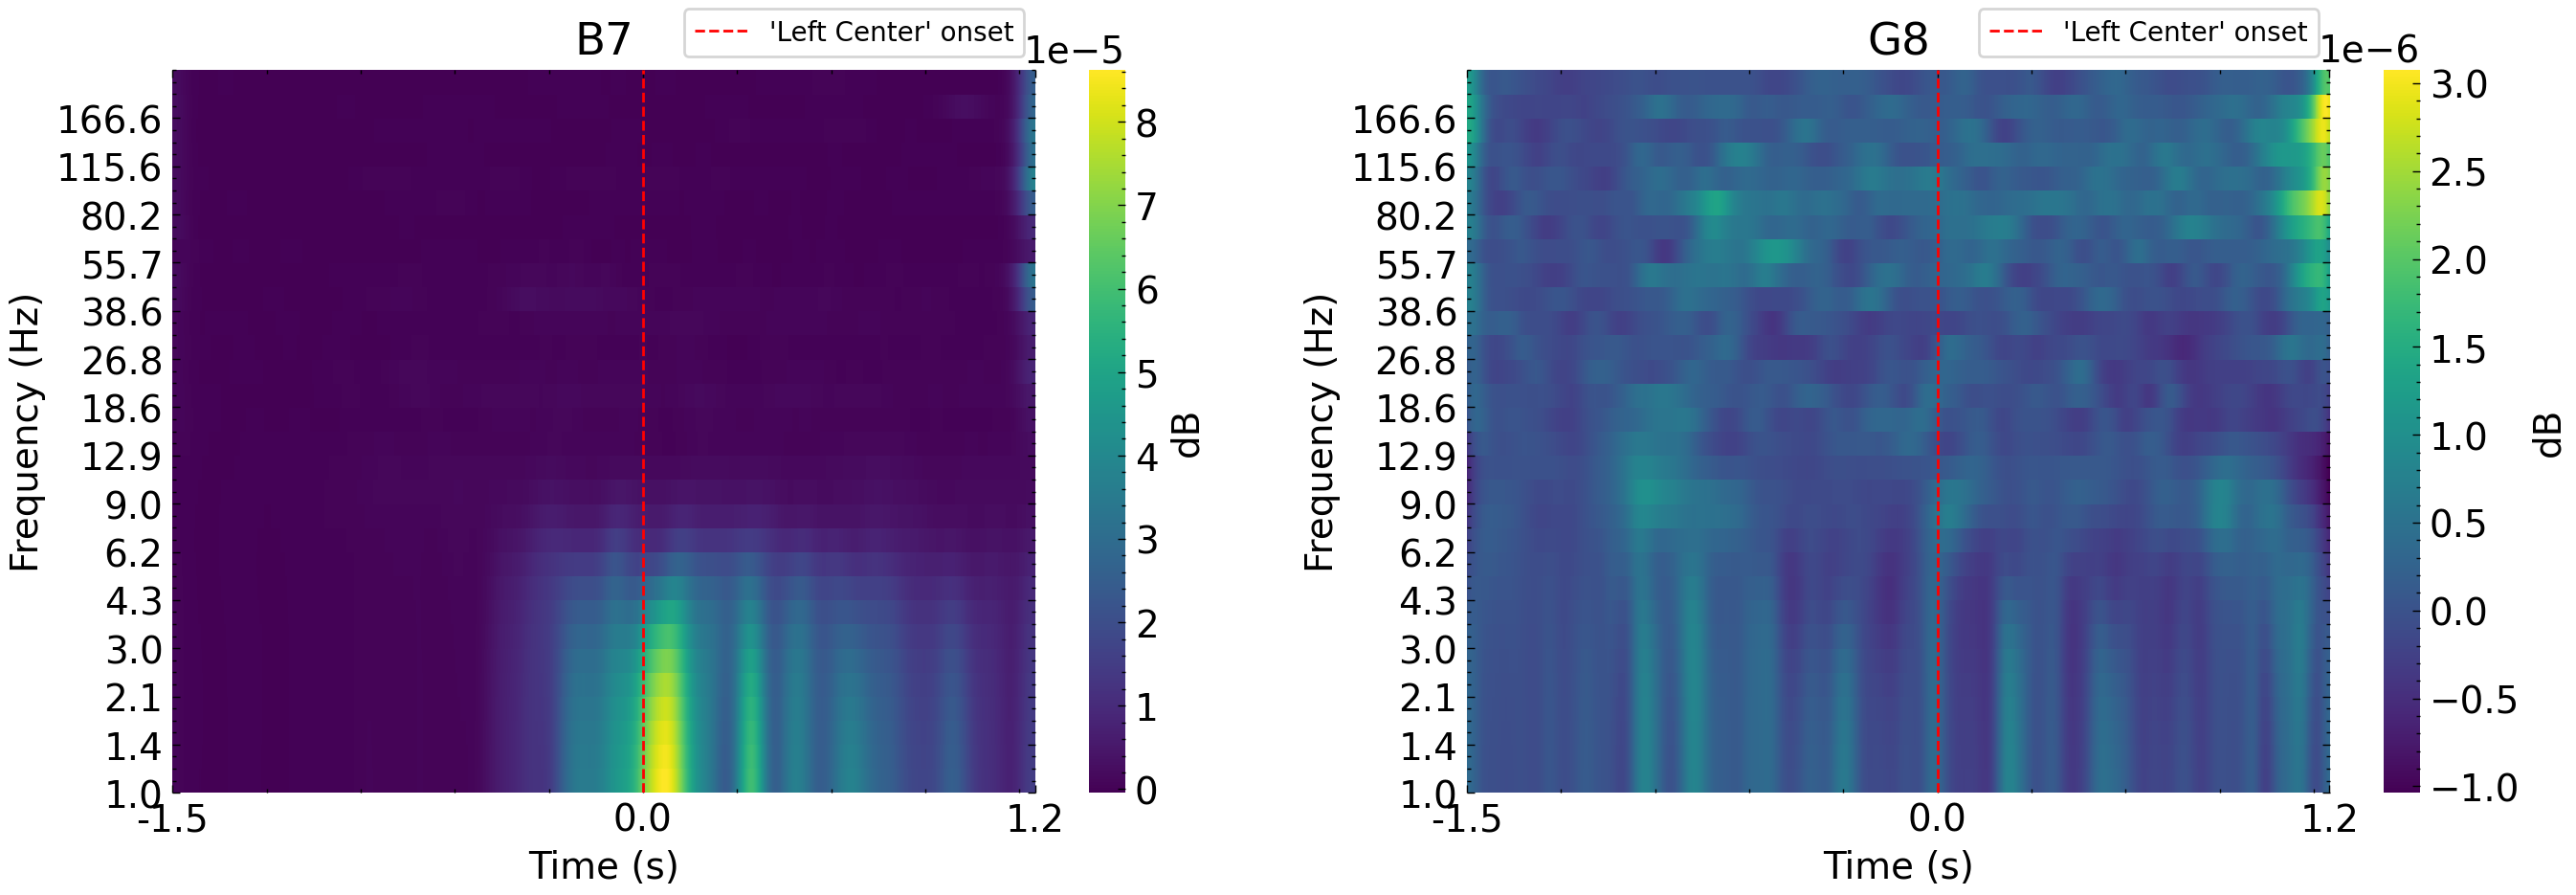

In [9]:
power = morlet_power.apply_baseline((-1.5, -1.0), mode="zscore")
plt.rcParams.update({"font.size": 14})
fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=200)
axs = axs.flatten()
plot_spectrogram(power, freqs, n_cycles, picks, axs=axs);

### Multitaper transform

In [10]:
nfreqs = 30
lfreq, hfreq = (1, 200)
freqs = np.linspace(lfreq, hfreq, num=nfreqs)
n_cycles = freqs / 3.0
multitaper_power = tfr_multitaper(
    epochs, freqs=freqs, n_cycles=n_cycles, average=False, return_itc=False, decim=3, n_jobs=-1
)

Loading data for 96 events and 5501 original time points ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   21.1s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:  2.2min finished


Not setting metadata


Applying baseline correction (mode: zscore)


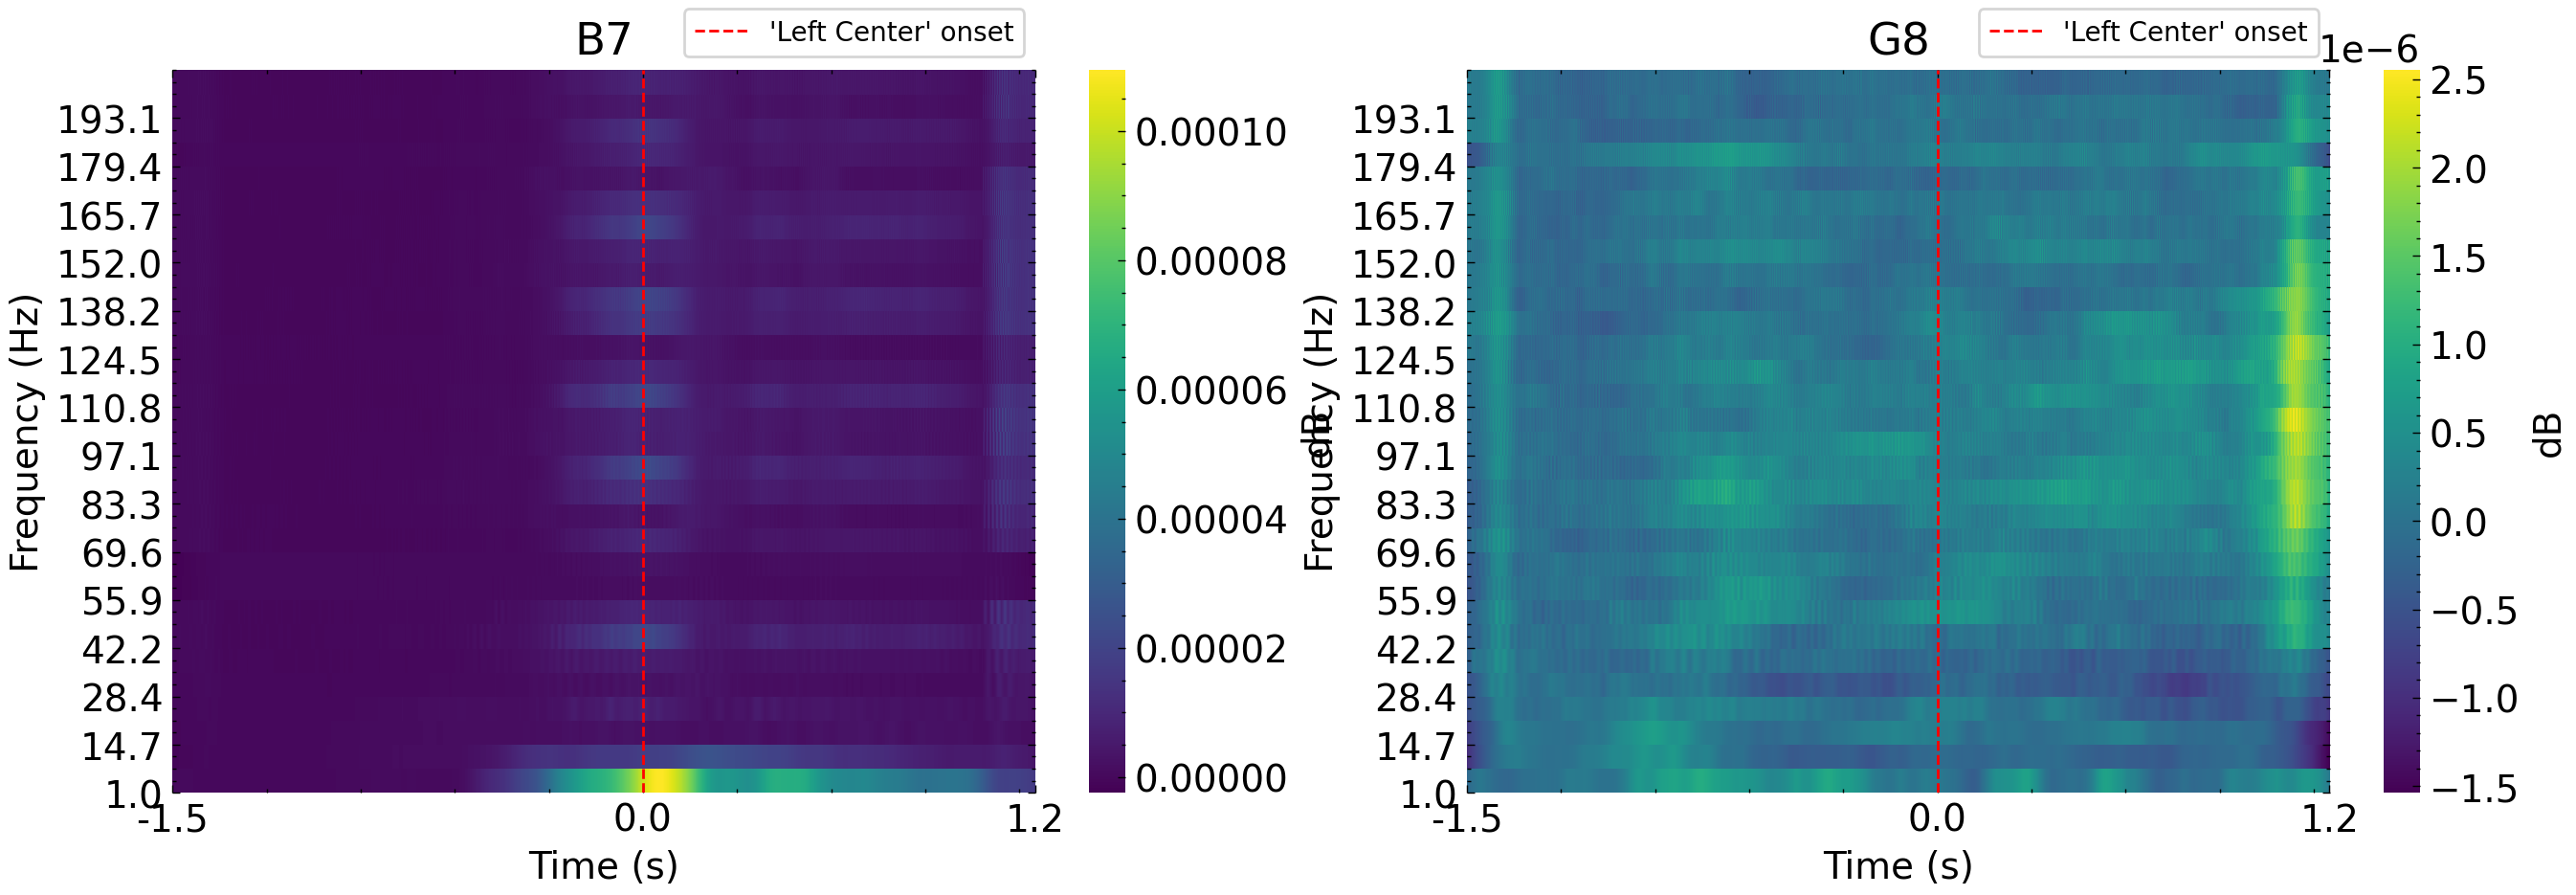

In [11]:
plt.rcParams.update({"font.size": 14})
power = multitaper_power.apply_baseline((-1.5, -1.0), mode="zscore")
fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=200)
axs = axs.flatten()
plot_spectrogram(power, freqs, n_cycles, picks, axs=axs);

## Accuracy/AUC Plots

### Time domain

In [25]:
go_cue_durations = get_event_durations(
    bids_path, event_key="Left Target", periods=-1
)
left_target_durations = get_event_durations(
    bids_path, event_key="Left Target", periods=1
)

tmin = -max(go_cue_durations)
tmax = max(left_target_durations)

epochs, labels = get_event_data(bids_path, tmin=tmin - 0.2, tmax=tmax + 0.2)

data = epochs.get_data()
ntrials, nchs, nsteps = data.shape
print(f"{subject.upper()}: data.shape = ({data.shape})")

t = epochs.times
mask = (t >= -np.asarray(go_cue_durations)[:, None, None]) & (
    t <= np.asarray(left_target_durations)[:, None, None]
)
masked_data = data * mask

image_height = nchs
image_width = nsteps

/Users/ChesterHuynh/.local/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any electrodes.tsv associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Volumes/Mac/research/data/efri/sub-efri07/**/sub-efri07_ses-efri*electrodes.tsv"
  warn(msg)
/Users/ChesterHuynh/.local/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any coordsystem.json associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Volumes/Mac/research/data/efri/sub-efri07/**/sub-efri07_ses-efri*coordsystem.json"
  warn(msg)


EFRI07: data.shape = ((76, 75, 1748))


In [26]:
clfs = initialize_classifiers(image_height, image_width, n_jobs=-1, random_state=rng)
clf_scores = {}
for clf in clfs:
    if isinstance(clf, rerfClassifier):
        clf_name = clf.get_params()["projection_matrix"]
    elif isinstance(clf, DummyClassifier):
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__
    
    filename = results_path / subject / f"trial_specific_window/time_domain/{subject}_{clf_name}_results.json"
    with open(filename) as f:
        clf_scores[clf_name] = json.load(f)

#### ROC curves

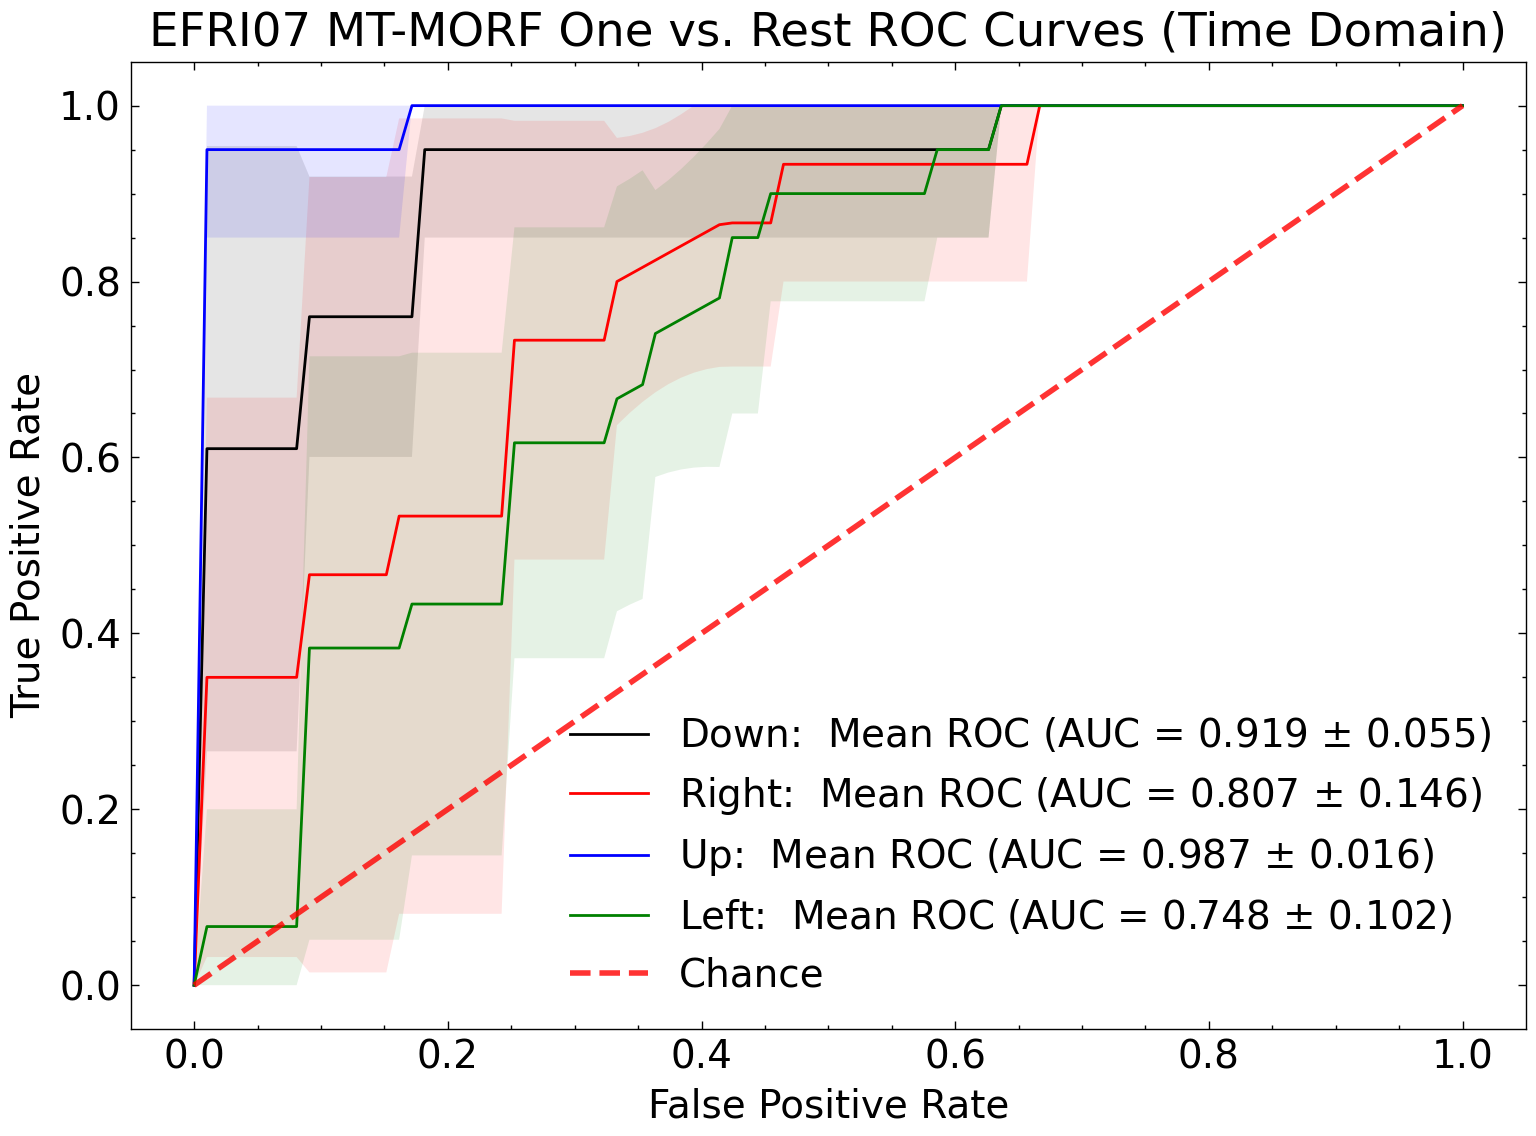

In [27]:
scores = clf_scores["MT-MORF"]
X = masked_data.reshape(ntrials, -1)
y = labels

plt.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(dpi=200, figsize=(8, 6))
plot_roc_multiclass_cv(
    scores["test_predict_proba"],
    X,
    y,
    scores["test_inds"],
    ax=ax,
)

ax.set(
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Time Domain)",
)
ax.legend(loc="lower right")
fig.tight_layout();

#### Classifier comparison

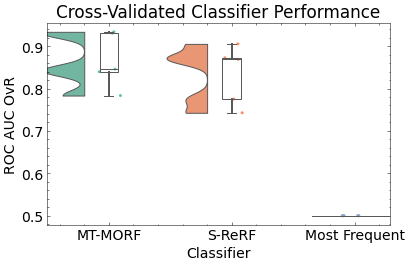

In [28]:
mtmorf_scores = clf_scores["MT-MORF"]
srerf_scores = clf_scores["S-RerF"]
dummy_scores = clf_scores["most_frequent"]

rocs = {
    "MT-MORF": mtmorf_scores["test_roc_auc_ovr"],
    "S-ReRF": srerf_scores["test_roc_auc_ovr"],
    "Most Frequent": dummy_scores["test_roc_auc_ovr"]
}
df = pd.DataFrame(rocs)
df = pd.melt(df, value_vars=list(rocs.keys()), var_name="Classifier", value_name="ROC AUC OvR")

plt.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(figsize=(6, 4))
pt.RainCloud(x="Classifier", y="ROC AUC OvR", data=df, ax=ax)
ax.set_title("Cross-Validated Classifier Performance")
fig.tight_layout();

/opt/anaconda3/envs/motor-decoding/lib/python3.8/site-packages/dabest/_classes.py:774: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="lower",
/opt/anaconda3/envs/motor-decoding/lib/python3.8/site-packages/dabest/_classes.py:779: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="upper",
/opt/anaconda3/envs/motor-decoding/lib/python3.8/site-packages/dabest/_classes.py:774: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="lower",
/opt/anaconda3/envs/motor-decoding/lib/python3.8/site-packages/dabest/_classes.py:779: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substit

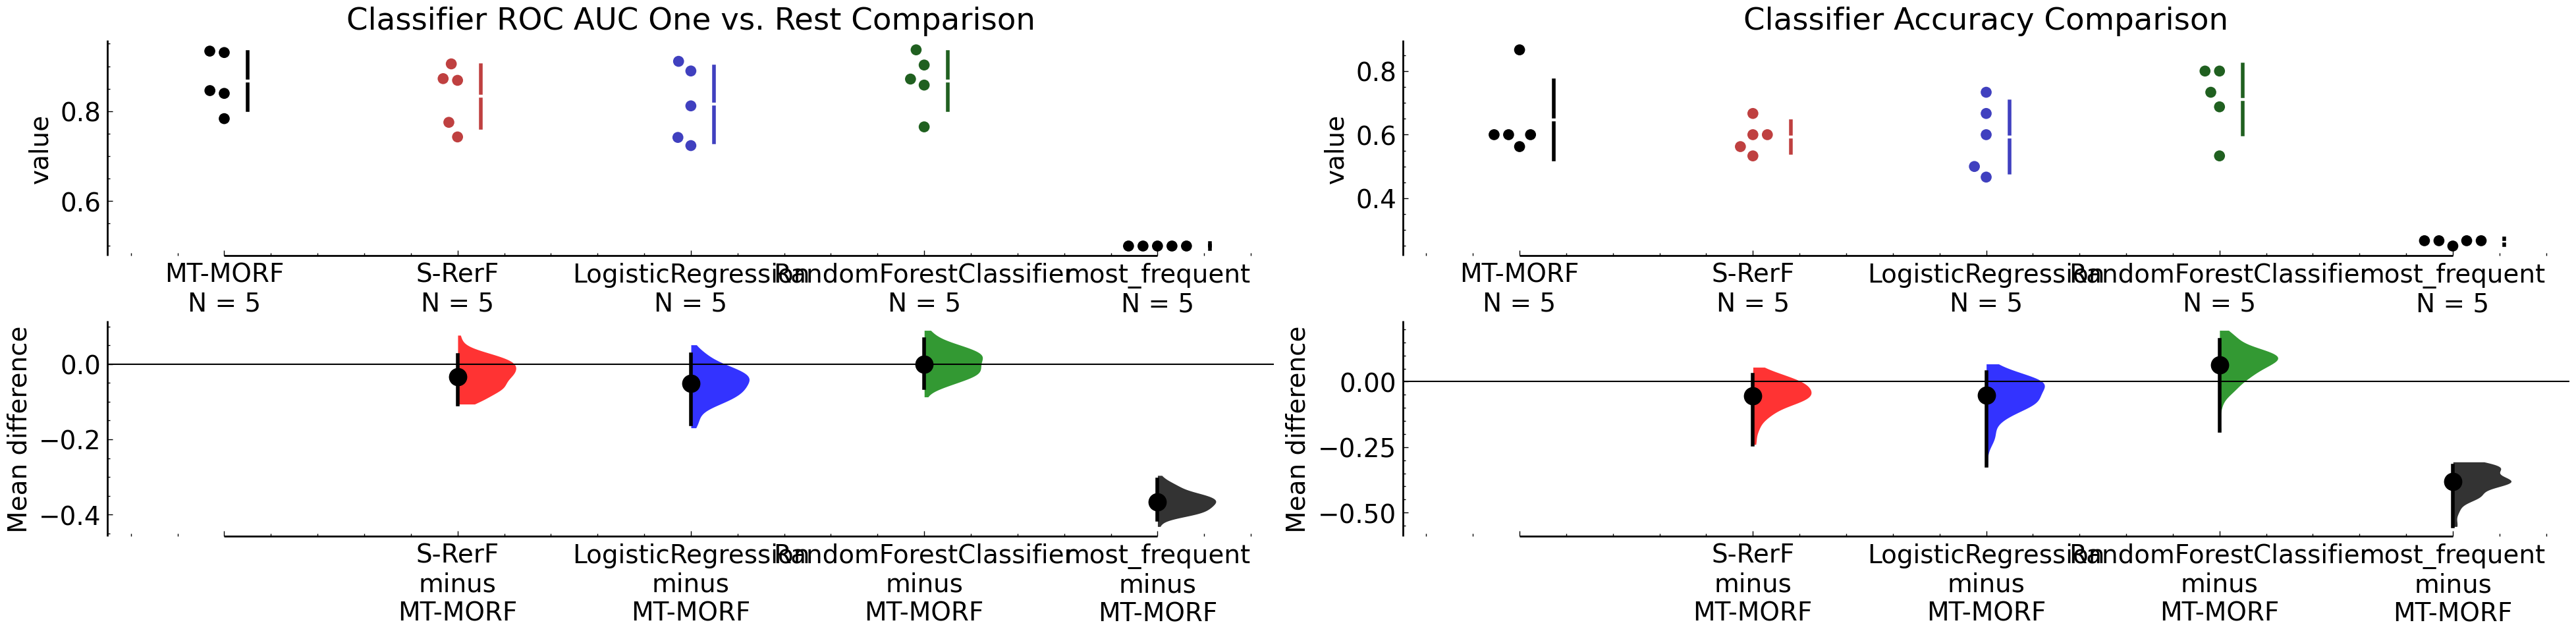

In [30]:
fig, axs = plt.subplots(ncols=2, dpi=200, figsize=(20, 3))
axs = axs.flatten()
plot_classifier_performance(clf_scores, X, y, axs=axs)
fig.tight_layout();

#### Feature importances

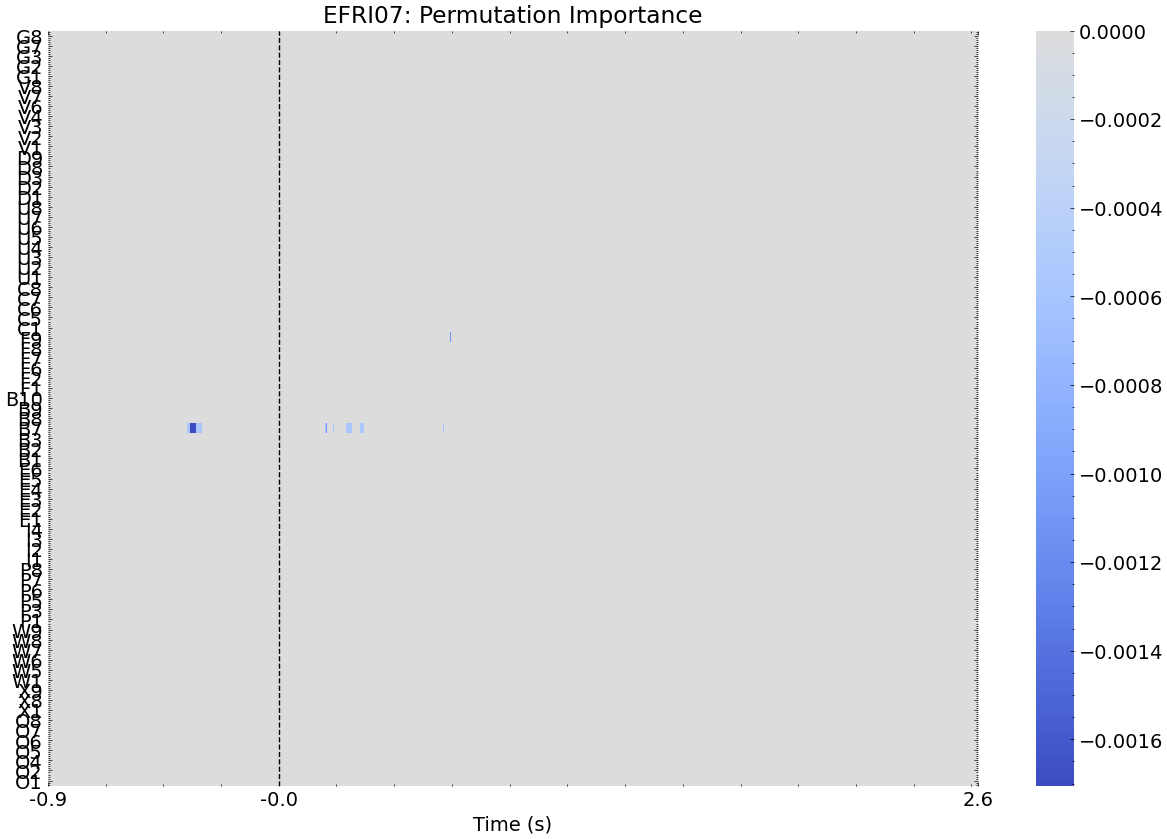

In [17]:
image_height = nchs
image_width = nsteps

scoring_method = "roc_auc_ovr"
scores = clf_scores['MT-MORF']
result = dict(
    importances_mean=np.array(scores[f"validate_{scoring_method}_imp_mean"]), 
    importances_std=np.array(scores[f"validate_{scoring_method}_imp_std"]
))

# importances_mean = np.array(result["importances_mean"]).reshape(image_height, image_width)
# significant_chs = np.where(~np.isclose(np.sum(np.abs(importances_mean), axis=1), 0))[0]
# ordering = np.argsort(np.count_nonzero(importances_mean[significant_chs], axis=1))[::-1]
# significant_chs = significant_chs[ordering]

# subsetted_results = dict(
#     importances_mean=result["importances_mean"].reshape(image_height, image_width)[significant_chs],
#     importances_std=result["importances_std"].reshape(image_height, image_width)[significant_chs]
# )

fig, ax = plt.subplots(dpi=100, figsize=(15, 10))
# plot_feature_importances(subsetted_results, np.array(epochs.ch_names)[significant_chs], power.times, len(significant_chs), image_width, ax=ax)
plot_feature_importances(result, epochs.ch_names, epochs.times, image_height, image_width, ax=ax)
ax.set(title=f"{subject.upper()}: Permutation Importance");

### Frequency domain

In [18]:
nfreqs = 10
lfreq, hfreq = (70, 200)
freqs = np.logspace(*np.log10([lfreq, hfreq]), num=nfreqs)
n_cycles = freqs / 3.0

go_cue_durations = get_event_durations(
    bids_path, event_key="Left Target", periods=-1
)
left_target_durations = get_event_durations(
    bids_path, event_key="Left Target", periods=1
)

tmin = -max(go_cue_durations)
tmax = max(left_target_durations)

epochs, labels = get_event_data(bids_path, tmin=tmin - 0.2, tmax=tmax + 0.2)

power = tfr_morlet(
            epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            average=False,
            return_itc=False,
            decim=3,
            n_jobs=-1,
)
power.crop(tmin=tmin, tmax=tmax)
data = power.data
ntrials, nchs, nfreqs, nsteps = data.shape
print(f"{subject.upper()}: data.shape = ({data.shape})")

t = power.times
mask = (t >= -np.asarray(go_cue_durations)[:, None, None, None]) & (
    t <= np.asarray(left_target_durations)[:, None, None, None]
)
masked_data = data * mask

image_height = nchs * nfreqs
image_width = nsteps

/Users/ChesterHuynh/.local/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any electrodes.tsv associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Volumes/Mac/research/data/efri/sub-efri07/**/sub-efri07_ses-efri*electrodes.tsv"
  warn(msg)
/Users/ChesterHuynh/.local/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any coordsystem.json associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Volumes/Mac/research/data/efri/sub-efri07/**/sub-efri07_ses-efri*coordsystem.json"
  warn(msg)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:    6.0s finished


EFRI07: data.shape = ((76, 75, 10, 516))


In [19]:
clfs = initialize_classifiers(image_height, image_width, n_jobs=-1, random_state=rng)
clf_scores = {}
for clf in clfs:
    if isinstance(clf, rerfClassifier):
        clf_name = clf.get_params()["projection_matrix"]
    elif isinstance(clf, DummyClassifier):
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__
    
    filename = results_path / subject / f"trial_specific_window/freq_domain/{subject}_{clf_name}_results.json"
    with open(filename) as f:
        clf_scores[clf_name] = json.load(f)

#### ROC curves

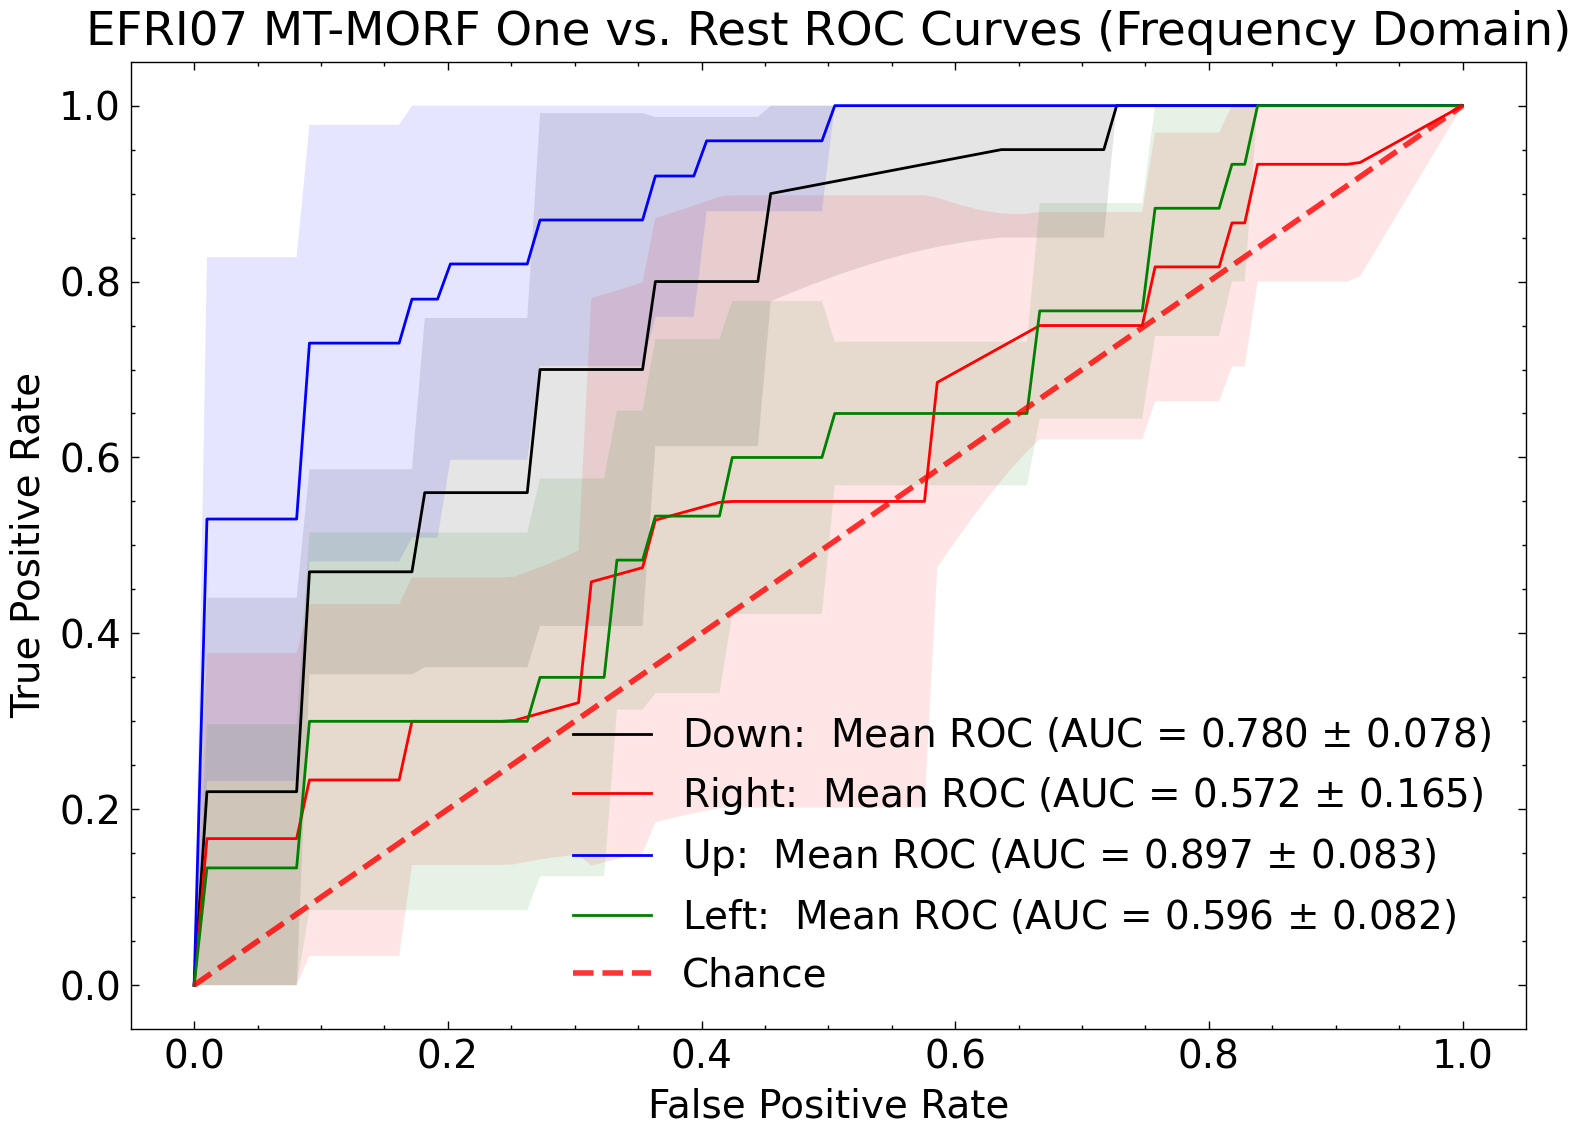

In [20]:
scores = clf_scores["MT-MORF"]
X = masked_data.reshape(ntrials, -1)
y = labels

plt.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(dpi=200, figsize=(8, 6))
plot_roc_multiclass_cv(
    scores["test_predict_proba"],
    X,
    y,
    scores["test_inds"],
    ax=ax,
)

ax.set(
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Frequency Domain)",
)
ax.legend(loc="lower right")
fig.tight_layout();

#### Classifier comparison

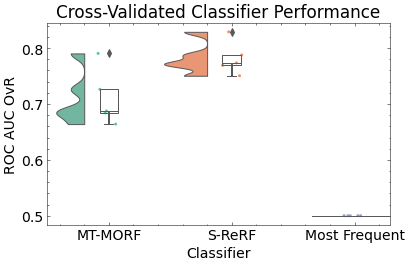

In [21]:
mtmorf_scores = clf_scores["MT-MORF"]
srerf_scores = clf_scores["S-RerF"]
dummy_scores = clf_scores["most_frequent"]

rocs = {
    "MT-MORF": mtmorf_scores["test_roc_auc_ovr"],
    "S-ReRF": srerf_scores["test_roc_auc_ovr"],
    "Most Frequent": dummy_scores["test_roc_auc_ovr"]
}
df = pd.DataFrame(rocs)
df = pd.melt(df, value_vars=list(rocs.keys()), var_name="Classifier", value_name="ROC AUC OvR")

plt.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(figsize=(6, 4))
pt.RainCloud(x="Classifier", y="ROC AUC OvR", data=df, ax=ax)
ax.set_title("Cross-Validated Classifier Performance")
fig.tight_layout();

/opt/anaconda3/envs/motor-decoding/lib/python3.8/site-packages/dabest/_classes.py:774: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="lower",
/opt/anaconda3/envs/motor-decoding/lib/python3.8/site-packages/dabest/_classes.py:779: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="upper",
/opt/anaconda3/envs/motor-decoding/lib/python3.8/site-packages/dabest/_classes.py:774: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="lower",
/opt/anaconda3/envs/motor-decoding/lib/python3.8/site-packages/dabest/_classes.py:779: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substit

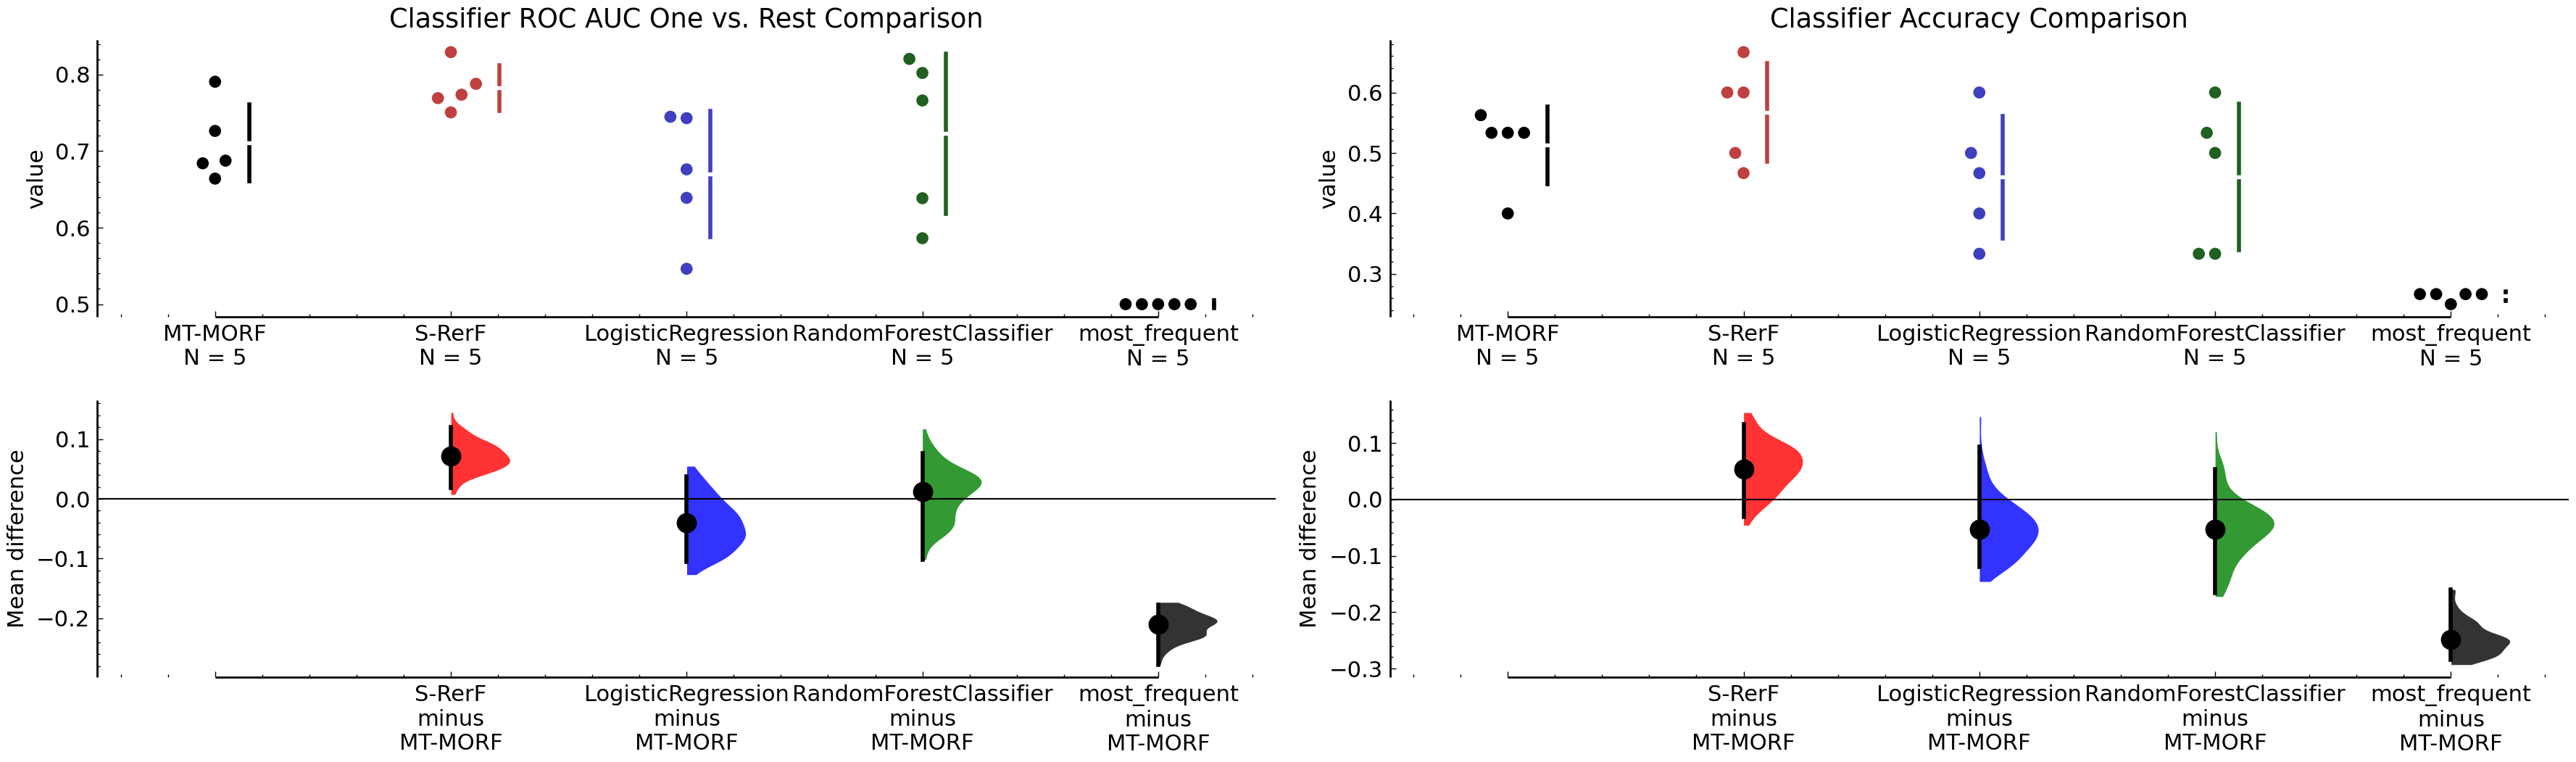

In [24]:
fig, axs = plt.subplots(ncols=2, dpi=200, figsize=(18, 3))
axs = axs.flatten()
plot_classifier_performance(clf_scores, X, y, axs=axs)
fig.tight_layout();

#### Feature importances

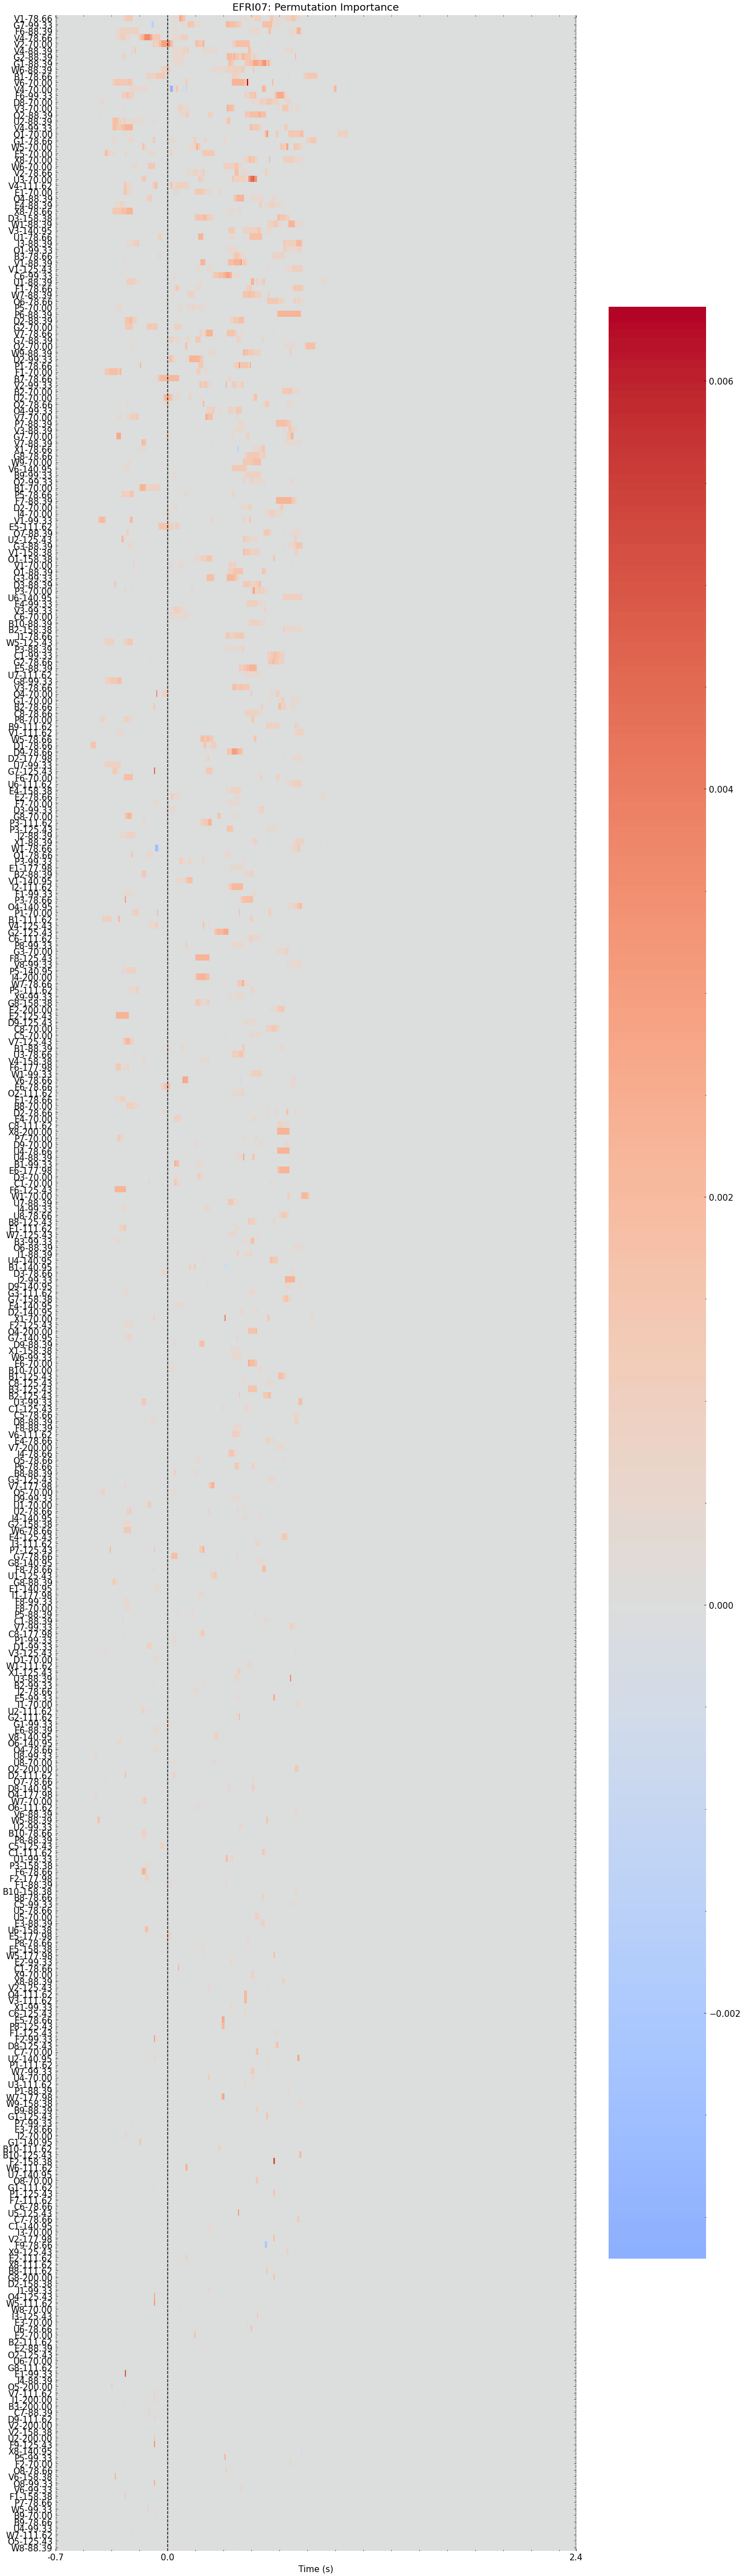

In [23]:
image_height = nchs*nfreqs
image_width = nsteps

scoring_method = "roc_auc_ovr"
scores = clf_scores['MT-MORF']
result = dict(
    importances_mean=np.array(scores[f"validate_{scoring_method}_imp_mean"]), 
    importances_std=np.array(scores[f"validate_{scoring_method}_imp_std"]
))

importances_mean = np.array(result["importances_mean"]).reshape(image_height, image_width)
significant_chs = np.where(~np.isclose(np.sum(np.abs(importances_mean), axis=1), 0))[0]
ordering = np.argsort(np.count_nonzero(importances_mean[significant_chs], axis=1))[::-1]
significant_chs = significant_chs[ordering]

power_ch_names = [f"{ch}-{f:.2f}" for ch in power.ch_names for f in freqs]
subsetted_results = dict(
    importances_mean=result["importances_mean"].reshape(image_height, image_width)[significant_chs],
    importances_std=result["importances_std"].reshape(image_height, image_width)[significant_chs]
)

plt.rcParams.update({"font.size": 11})
fig, ax = plt.subplots(dpi=100, figsize=(15, 60))
plot_feature_importances(subsetted_results, np.array(power_ch_names)[significant_chs], power.times, len(significant_chs), image_width, ax=ax)
ax.set(title=f"{subject.upper()}: Permutation Importance");